In [1]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed 
set_random_seed(2)

from keras import backend as K

from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf 
from keras import metrics
from keras.callbacks import ModelCheckpoint

import pandas as pd 
import math as m
import os, glob

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [91]:
MODEL_NAME = "LSTM"
NUM_FEATURES = 0 
TARGET_NAME = ""
MSE_RESULT = 0

In [3]:
RANGE = 51

HYPER_L1_IN = RANGE
EPOCHS = 100
BATCH_SIZE = 32

TEST_SIZE = .19
VAL_SIZE = .0

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [4]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

DF_EURUSD_ASK_1H_PROC.csv


In [27]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
DATASET = pd.read_csv(filenames[0], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
DATASET.head()


,Gmt time,Open,High,Low,Close,Volume,day_name,weekday,Pct_Range_Close,Pct_Range_Close_diff,MA_Close_5,MA_Close_25,MA_Close_50,MA_Close_200
0,2018-01-01 22:00:00,1.20143,1.20173,1.20062,1.20158,1623.5100,Monday,0,0.000000,0.000000,0.00000,0.0,0.0,0.0
1,2018-01-01 23:00:00,1.20158,1.20161,1.20044,1.20110,6297.2402,Monday,0,-0.000399,-0.000399,0.00000,0.0,0.0,0.0
2,2018-01-02 00:00:00,1.20109,1.20178,1.20096,1.20162,3564.4600,Tuesday,1,0.000433,0.000832,0.00000,0.0,0.0,0.0
3,2018-01-02 01:00:00,1.20162,1.20232,1.20141,1.20159,6219.6899,Tuesday,1,-0.000025,-0.000458,0.00000,0.0,0.0,0.0
4,2018-01-02 02:00:00,1.20157,1.20165,1.20081,1.20096,5386.5098,Tuesday,1,-0.000524,-0.000499,1.20137,0.0,0.0,0.0


In [29]:
#Describe DATASET
print('Shape: ', DATASET.shape)
print(DATASET.describe())
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.dtypes)


Shape:  (15023, 14)
               Open          High           Low         Close         Volume  \
count  15023.000000  15023.000000  15023.000000  15023.000000   15023.000000   
mean       1.141308      1.141974      1.140634      1.141303   10819.459016   
std        0.043208      0.043281      0.043139      0.043206    8543.286582   
min        1.065520      1.066840      1.063640      1.065500       1.050000   
25%        1.109760      1.110295      1.109205      1.109760    5099.780000   
50%        1.131230      1.131880      1.130610      1.131210    9308.469700   
75%        1.163455      1.164190      1.162600      1.163420   14606.439950   
max        1.254930      1.255560      1.254370      1.254930  278504.156300   

            weekday  Pct_Range_Close  Pct_Range_Close_diff    MA_Close_5  \
count  15023.000000     15023.000000          1.502300e+04  15023.000000   
mean       2.050057        -0.000005         -1.078057e-08      1.140995   
std        1.506042         0.0

In [30]:
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(14824, 12)
      Open     High      Low    Close      Volume  weekday  Pct_Range_Close  \
0  1.20538  1.20574  1.20402  1.20443   5914.2402        4        -0.000788   
1  1.20443  1.20524  1.20426  1.20485   6369.0498        4         0.000349   
2  1.20484  1.20756  1.20458  1.20627  14090.5400        4         0.001179   
3  1.20630  1.21208  1.20525  1.21114  18746.5391        4         0.004037   
4  1.21115  1.21370  1.21111  1.21255  18016.5898        4         0.001164   

   Pct_Range_Close_diff  MA_Close_5  MA_Close_25  MA_Close_50  MA_Close_200  
0             -0.000962    1.204850     1.201357     1.198699      1.200896  
1              0.001137    1.204908     1.201740     1.198924      1.200912  
2              0.000830    1.205220     1.202222     1.199193      1.200938  
3              0.002859    1.206414     1.202907     1.199557      1.200986  
4             -0.002873    1.207848     1.203656     1.199938      1.201041  


In [31]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  14824
Start:  0


In [32]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)

(14824, 12)


In [33]:

total = DF_Full.shape[0]
print('Total: ', total)

Total:  14824


In [34]:
#generate the VECTOR Y
close_y = DF_Full['Close'].iloc[1:]
close_y.columns = ['close_y']
print(close_y.head())
print(close_y.shape)
close_y = close_y.append(close_y.tail(1), ignore_index=True)
print(close_y.tail())
print(close_y.shape)


1    1.20485
2    1.20627
3    1.21114
4    1.21255
5    1.21190
Name: Close, dtype: float64
(14823,)
14819    1.11071
14820    1.11141
14821    1.11123
14822    1.11158
14823    1.11158
Name: Close, dtype: float64
(14824,)


In [35]:
s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.19
count of Val and Test: 2816
end of train:  12008
count val:  0
count test:  2816
end_val 12008


In [36]:
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print(data_training.shape)
print(data_val.shape)
print(data_test.shape)

data_training_y = close_y.iloc[:end_train]
data_val_y = close_y.iloc[end_train: end_val]
data_test_y = close_y.iloc[end_val:]

print(data_training_y.shape)
print(data_val_y.shape)
print(data_test_y.shape)

(12008, 12)
(0, 12)
(2816, 12)
(12008,)
(0,)
(2816,)


In [37]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
#print(data_training.head)
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[0.70308006 0.70085265 0.69748858 ... 0.69390511 0.68497185 0.71654913]
 [0.69738734 0.69785037 0.69893055 ... 0.69628339 0.68640218 0.71665924]
 [0.6998442  0.71178095 0.70085316 ... 0.69927237 0.68811399 0.71683332]
 ...
 [0.15502157 0.15083463 0.15332853 ... 0.15108003 0.15086234 0.10753042]
 [0.15298418 0.14915336 0.15326845 ... 0.15140028 0.15026753 0.10773817]
 [0.15388303 0.15035427 0.15477049 ... 0.1517379  0.14970585 0.10794492]]


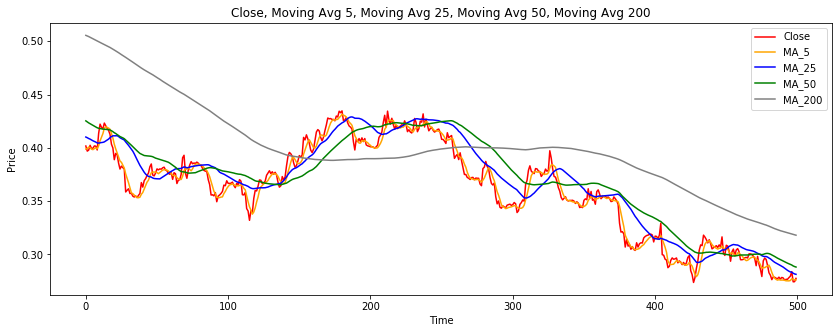

In [49]:
INICIO = 4500
FIN = 5000
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,3], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,8], color = 'orange', label = 'MA_5')
pyplot.plot(data_training_array_scaled[INICIO:FIN,9], color = 'blue', label = 'MA_25')
pyplot.plot(data_training_array_scaled[INICIO:FIN,10], color = 'green', label = 'MA_50')
pyplot.plot(data_training_array_scaled[INICIO:FIN,11], color = 'gray', label = 'MA_200')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

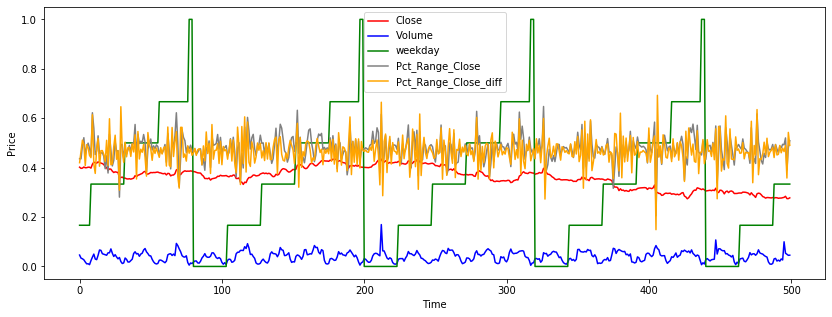

In [46]:
INICIO = 4500
FIN = 5000
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,3], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,4], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,5], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,6], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,7], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

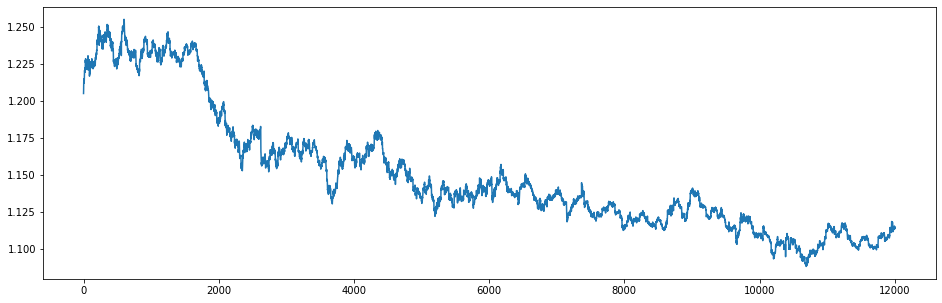

In [50]:
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [51]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(11957, 51, 12)
(11957,)


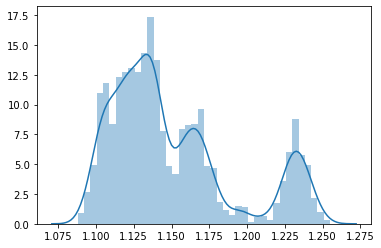

In [52]:
sns.distplot(y_train_np);



In [53]:

#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(51, 12)
(0, 12)
<bound method NDFrame.head of        Open     High      Low    Close      Volume  weekday  Pct_Range_Close  \
0   1.11833  1.11935  1.11771  1.11835   8116.7998        3        -0.000045   
1   1.11836  1.11836  1.11684  1.11699   7641.5601        4        -0.001216   
2   1.11699  1.11820  1.11682  1.11770   6966.9199        4         0.000636   
3   1.11769  1.11814  1.11725  1.11739   4586.2798        4        -0.000277   
4   1.11741  1.11781  1.11703  1.11779   4806.7202        4         0.000358   
5   1.11777  1.11779  1.11709  1.11712   3297.9199        4        -0.000599   
6   1.11712  1.11761  1.11708  1.11747   3958.2900        4         0.000313   
7   1.11746  1.11748  1.11631  1.11671   5909.3799        4        -0.000680   
8   1.11670  1.11681  1.11631  1.11657  13220.6504        4        -0.000125   
9   1.11657  1.11810  1.11650  1.11774  15447.5703        4         0.001048   
10  1.11775  1.11819  1.11689  1.11804  13416.3496        4         0.000

In [54]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y.tail(RANGE)
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = last_range_train_y.append(data_val_y, ignore_index = True)
data_val_y1.shape
print(data_val_y1.head(10))

(51,)
(0,)
0    1.11699
1    1.11770
2    1.11739
3    1.11779
4    1.11712
5    1.11747
6    1.11671
7    1.11657
8    1.11774
9    1.11804
Name: Close, dtype: float64


In [55]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[0.18144775 0.18211841 0.17892334 0.18156759 0.03210355 0.5
  0.47683291 0.21105335 0.1580473  0.14857515 0.12994486 0.09666454]
 [0.18162752 0.17617389 0.17369623 0.17341802 0.03022267 0.66666667
  0.40220631 0.40399978 0.16489529 0.14949369 0.1309154  0.09698038]
 [0.17341802 0.17521316 0.17357606 0.17767258 0.02755261 0.66666667
  0.52017678 0.56567839 0.17029397 0.15046188 0.13199038 0.09732316]
 [0.17761266 0.17485289 0.17615958 0.17581496 0.01813061 0.66666667
  0.46201115 0.4178182  0.17543902 0.15130346 0.13303479 0.09764372]
 [0.1759348  0.17287138 0.17483778 0.17821189 0.01900306 0.66666667
  0.50248741 0.50062467 0.17470229 0.15214007 0.13408429 0.09797808]
 [0.17809204 0.17275129 0.17519827 0.17419703 0.01303159 0.66666667
  0.44149426 0.4154446  0.17321674 0.15282277 0.1350803  0.09826833]
 [0.17419703 0.17167047 0.17513819 0.17629434 0.01564518 0.66666667
  0.49964145 0.5154588  0.17379647 0.15363208 0.13612598 0.09858989]
 [0.17623442 0.17088988 0.1705119  0.17174017 0.

In [56]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(0,)
(0,)


In [57]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(51, 12)
(2816, 12)


(2867, 12)

In [58]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y.tail(RANGE)
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = last_range_training_y.append(data_test_y, ignore_index = True)
data_test_y1.shape

(51,)
(2816,)


(2867,)

In [59]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[0.18144775 0.18211841 0.17892334 0.18156759 0.03210355 0.5
  0.47683291 0.21105335 0.1580473  0.14857515 0.12994486 0.09666454]
 [0.18162752 0.17617389 0.17369623 0.17341802 0.03022267 0.66666667
  0.40220631 0.40399978 0.16489529 0.14949369 0.1309154  0.09698038]
 [0.17341802 0.17521316 0.17357606 0.17767258 0.02755261 0.66666667
  0.52017678 0.56567839 0.17029397 0.15046188 0.13199038 0.09732316]
 [0.17761266 0.17485289 0.17615958 0.17581496 0.01813061 0.66666667
  0.46201115 0.4178182  0.17543902 0.15130346 0.13303479 0.09764372]
 [0.1759348  0.17287138 0.17483778 0.17821189 0.01900306 0.66666667
  0.50248741 0.50062467 0.17470229 0.15214007 0.13408429 0.09797808]
 [0.17809204 0.17275129 0.17519827 0.17419703 0.01303159 0.66666667
  0.44149426 0.4154446  0.17321674 0.15282277 0.1350803  0.09826833]
 [0.17419703 0.17167047 0.17513819 0.17629434 0.01564518 0.66666667
  0.49964145 0.5154588  0.17379647 0.15363208 0.13612598 0.09858989]
 [0.17623442 0.17088988 0.1705119  0.17174017 0.

In [60]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(2816, 51, 12)
(2816,)


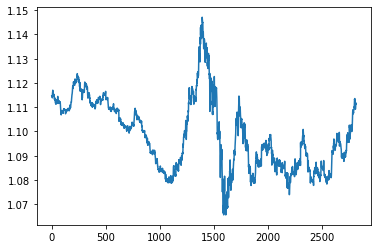

In [61]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

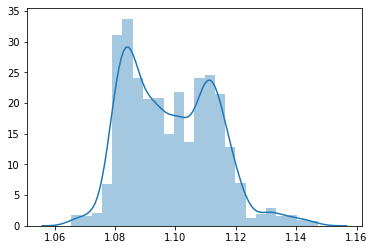

In [62]:
sns.distplot(y_test_np);


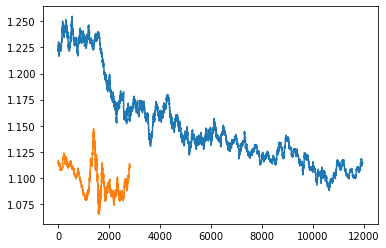

In [63]:

# Y de Val y Test comparados
pyplot.plot(y_train_np)
pyplot.plot(y_test_np)
pyplot.plot(y_val_np)


In [64]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

51
12


In [65]:
regressior = Sequential()

regressior.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 120, activation = 'relu'))
#regressior.add(Dropout(0.2))

regressior.add(Dense(units = 1))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [66]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [67]:
regressior.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

In [68]:
regressior.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 51, 51)            13056     
_________________________________________________________________
lstm_1 (LSTM)                (None, 51, 60)            26880     
_________________________________________________________________
lstm_2 (LSTM)                (None, 51, 80)            45120     
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               96480     
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 181,657
Trainable params: 181,657
Non-trainable params: 0
_________________________________________________________________


In [70]:
pwd = os.getcwd()
source_data = os.path.join(pwd, r'../../../Models/2020/LSTM/')
print(source_data)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models/../../../Models/2020/LSTM/


In [71]:
#Model check pointer para almacenar el modelo cada epoca
checkpointer = ModelCheckpoint(filepath=source_data + '/model-{epoch:02d}.hdf5', verbose=1)

In [72]:
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np), callbacks=[checkpointer], shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 11957 samples
Epoch 1/100
11957/11957 [==============================] - 69s 6ms/sample - loss: 0.0967 - mean_squared_error: 0.0967 - mean_absolute_error: 0.1295 - mean_absolute_percentage_error: 11.2692 - cosine_proximity: 0.9967
Epoch 2/100
11957/11957 [==============================] - 70s 6ms/sample - loss: 4.9988e-05 - mean_squared_error: 4.9988e-05 - mean_absolute_error: 0.0054 - mean_absolute_percentage_error: 0.4657 - cosine_proximity: 1.0000
Epoch 3/100
11957/11957 [==============================] - 72s 6ms/sample - loss: 2.6098e-05 - mean_squared_error: 2.6098e-05 - mean_absolute_error: 0.0039 - mean_absolute_percentage_error: 0.3393 - cosine_proximity: 1.0000
Epoch 4/100
11957/11957 [==============================] - 66s 6ms/sample - loss: 2.0865e-05 - mean_squared_error: 2.0865e-05 - mean_absolute_error: 0.0035 - mean_absolute_percentage_error: 0.3052 - cosine_proximity: 1

11957/11957 [==============================] - 62s 5ms/sample - loss: 3.3026e-05 - mean_squared_error: 3.3026e-05 - mean_absolute_error: 0.0042 - mean_absolute_percentage_error: 0.3677 - cosine_proximity: 1.0000
Epoch 36/100
11957/11957 [==============================] - 63s 5ms/sample - loss: 2.2177e-05 - mean_squared_error: 2.2177e-05 - mean_absolute_error: 0.0037 - mean_absolute_percentage_error: 0.3212 - cosine_proximity: 1.0000
Epoch 37/100
11957/11957 [==============================] - 64s 5ms/sample - loss: 1.8371e-05 - mean_squared_error: 1.8371e-05 - mean_absolute_error: 0.0034 - mean_absolute_percentage_error: 0.2968 - cosine_proximity: 1.0000
Epoch 38/100
11957/11957 [==============================] - 63s 5ms/sample - loss: 2.1835e-05 - mean_squared_error: 2.1835e-05 - mean_absolute_error: 0.0037 - mean_absolute_percentage_error: 0.3213 - cosine_proximity: 1.0000
Epoch 39/100
11957/11957 [==============================] - 62s 5ms/sample - loss: 2.4680e-05 - mean_squared_erro

11957/11957 [==============================] - 78s 7ms/sample - loss: 5.8255e-06 - mean_squared_error: 5.8255e-06 - mean_absolute_error: 0.0019 - mean_absolute_percentage_error: 0.1643 - cosine_proximity: 1.0000
Epoch 71/100
11957/11957 [==============================] - 70s 6ms/sample - loss: 7.5316e-06 - mean_squared_error: 7.5316e-06 - mean_absolute_error: 0.0022 - mean_absolute_percentage_error: 0.1876 - cosine_proximity: 1.0000
Epoch 72/100
11957/11957 [==============================] - 65s 5ms/sample - loss: 7.6299e-06 - mean_squared_error: 7.6299e-06 - mean_absolute_error: 0.0022 - mean_absolute_percentage_error: 0.1907 - cosine_proximity: 1.0000
Epoch 73/100
11957/11957 [==============================] - 63s 5ms/sample - loss: 6.4062e-06 - mean_squared_error: 6.4062e-06 - mean_absolute_error: 0.0019 - mean_absolute_percentage_error: 0.1680 - cosine_proximity: 1.0000
Epoch 74/100
11957/11957 [==============================] - 64s 5ms/sample - loss: 6.5014e-06 - mean_squared_erro

In [74]:
regressior.save(source_data + "LSTM_28Jun.hdf5")


In [75]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])


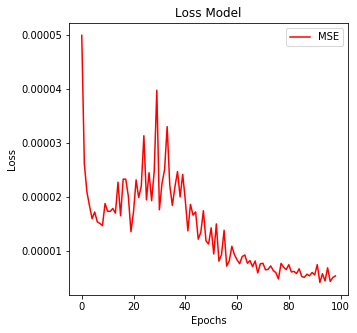

In [76]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
#plt.plot(history.history['val_loss'][1:], color = 'blue', label = 'Val_Loss')
plt.plot(history.history['mean_squared_error'][1:], color = 'red', label = 'MSE')
#plt.plot(history.history['mean_absolute_error'][1:], color = 'blue', label = 'MAE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

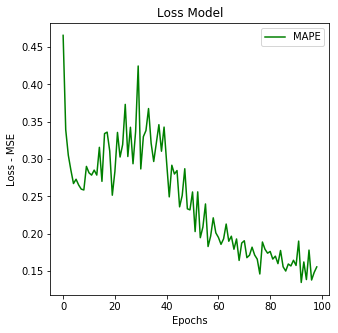

In [77]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
plt.plot(history.history['mean_absolute_percentage_error'][1:], color = 'green', label = 'MAPE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.legend()
plt.show()


In [78]:
#Load Model
filepath = os.path.join(source_data, r'LSTM_28Jun.hdf5')
#filepath = os.path.join(source_data, r'final_model.hdf5')
print(filepath)
model = tf.keras.models.load_model(filepath)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models/../../../Models/2020/LSTM/LSTM_28Jun.hdf5
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [79]:
y_test_pred = model.predict(X_test_np)
y_test_pred.shape



(2816, 1)

In [80]:
y_train_pred = model.predict(X_train_np)
y_train_pred.shape


(11957, 1)

(2816,)
(2816, 1)


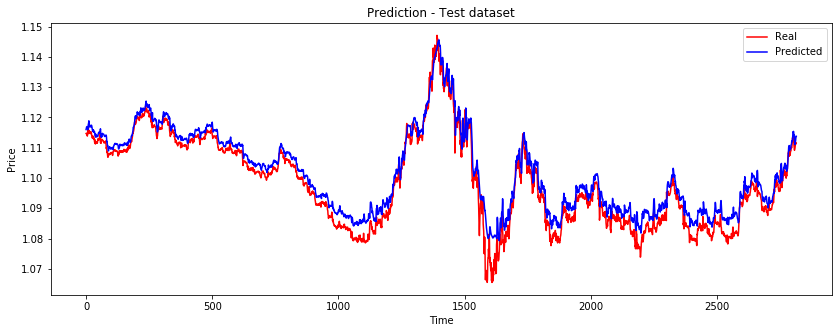

In [90]:
INICIO = 0
FIN = 2816
print(y_test_np.shape)
print(y_test_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_test_pred[INICIO:FIN], color = 'blue', label = 'Predicted')
plt.title('Prediction - Test dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [83]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [84]:
print('Test MAE:', mean_absolute_error(y_test_np, y_test_pred))#Mean Absolute Error
print('Test RMSE:',np.sqrt(mean_squared_error(y_test_np, y_test_pred)))#Root Mean Squared Error
print('Test MSE:',mean_squared_error(y_test_np, y_test_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_test_np, y_test_pred))#Mean Absolute Percentaje Error


Test MAE: 0.0033898667912727067
Test RMSE: 0.004065391960968254
Test MSE: 1.6527411796305307e-05
Test MAPE: 1.476808826409606


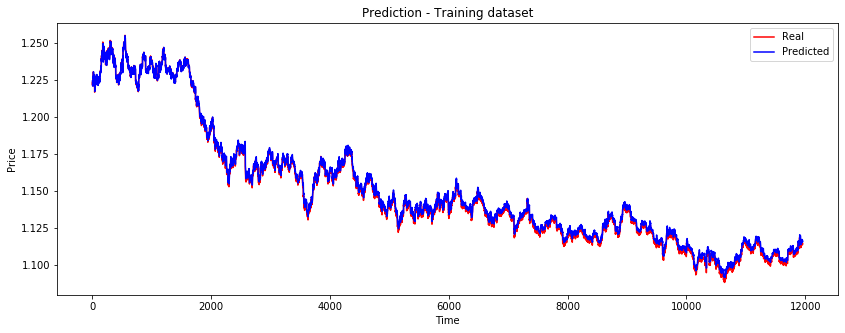

In [85]:

# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train_np, color = 'red', label = 'Real')
plt.plot(y_train_pred, color = 'blue', label = 'Predicted')
plt.title('Prediction - Training dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [86]:
print('Train MAE:', mean_absolute_error(y_train_np, y_train_pred))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(y_train_np, y_train_pred)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(y_train_np, y_train_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_train_np, y_train_pred))#Mean Absolute Percentaje Error


Train MAE: 0.0018078505081128267
Train RMSE: 0.002128351474058285
Train MSE: 4.529879997126075e-06
Test MAPE: 3.820683267562002


In [87]:
# Section to implement the ARIMA model from the library statsmodels.tsa.arima_model
# fit model
#model = ARIMA(series, order=(5,1,0))


train, test = y_train_np, y_test_np
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


Test MSE: 0.000


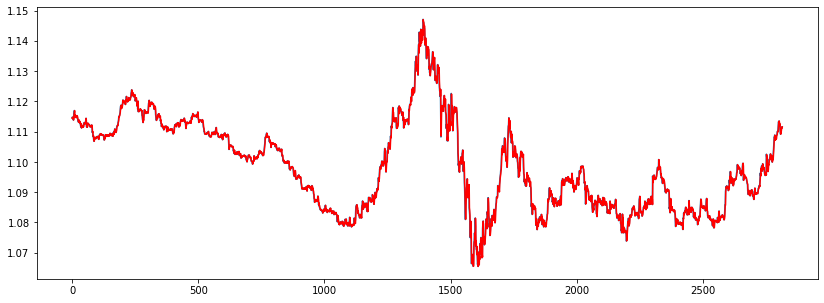

In [88]:
# plot
plt.figure(figsize=(14,5))
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [89]:
print('Train MAE:', mean_absolute_error(test, predictions))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(test, predictions)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(test, predictions))#Mean Squared Error

Train MAE: 0.0007811350045291688
Train RMSE: 0.0012554817734738196
Train MSE: 1.5762344835249674e-06


Archivo base, donde se separa X y Y correctamente, Y representa el valor Close de la siguiente hora. 
X tiene los historicos. Se separa 5000 para training y el resto para testing. 
